In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 30 23:21:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   34C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.622444328997517
GPU (s):
0.030678856004669797
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.resnet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
171458560/171446536 [==============================] - 133s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 30s 62ms/step - loss: 0.8789 - accuracy: 0.6820 - val_loss: 0.6771 - val_accuracy: 0.7239
Epoch 2/100
360/360 [==============================] - 21s 58ms/step - loss: 0.6495 - accuracy: 0.7374 - val_loss: 0.5969 - val_accuracy: 0.7532
Epoch 3/100
360/360 [==============================] - 20s 55ms/step - loss: 0.6099 - accuracy: 0.7548 - val_loss: 0.5547 - val_accuracy: 0.7721
Epoch 4/100
360/360 [==============================] - 19s 54ms/step - loss: 0.5871 - accuracy: 0.7664 - val_loss: 0.5451 - val_accuracy: 0.7673
Epoch 5/100
360/360 [==============================] - 20s 55ms/step - loss: 0.5658 - accuracy: 0.7710 - val_loss: 0.5514 - val_accuracy: 0.7645
Epoch 6/100
360/360 [================

360/360 [==============================] - 19s 52ms/step - loss: 0.4379 - accuracy: 0.8245 - val_loss: 0.4743 - val_accuracy: 0.8161
Epoch 55/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4340 - accuracy: 0.8286 - val_loss: 0.4701 - val_accuracy: 0.8112
Epoch 56/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4321 - accuracy: 0.8304 - val_loss: 0.4545 - val_accuracy: 0.8185
Epoch 57/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4343 - accuracy: 0.8271 - val_loss: 0.4650 - val_accuracy: 0.8110
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4291 - accuracy: 0.8329 - val_loss: 0.4582 - val_accuracy: 0.8163
Epoch 59/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4305 - accuracy: 0.8288 - val_loss: 0.4765 - val_accuracy: 0.8102
Epoch 60/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4296 - accuracy: 0.8299 - val_loss: 0.4650 - val_accuracy

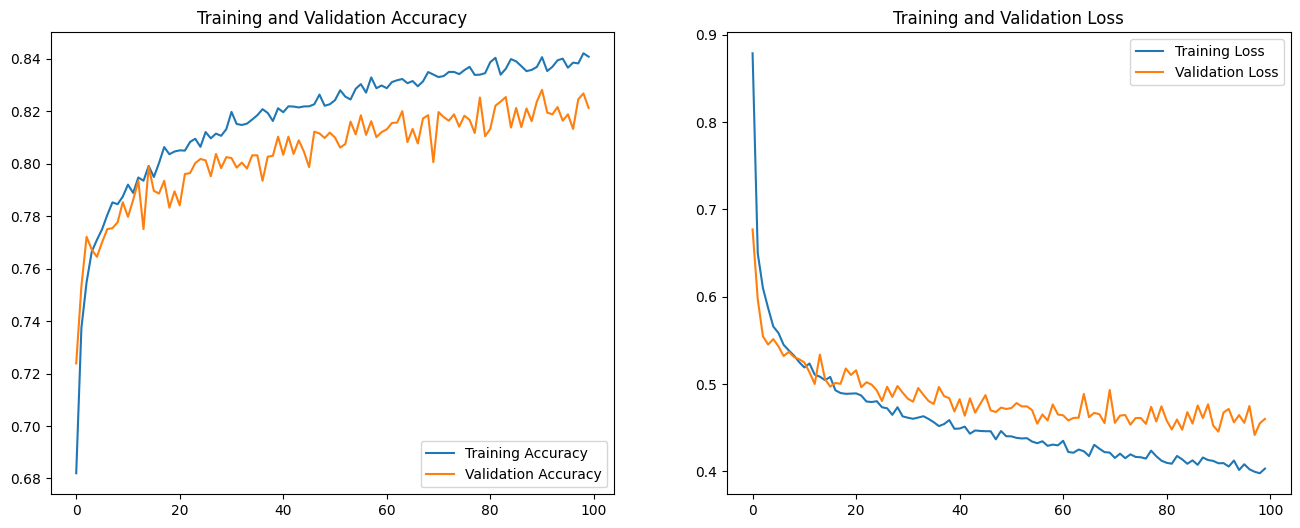

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 28s 57ms/step - loss: 0.9479 - accuracy: 0.6822 - val_loss: 0.6284 - val_accuracy: 0.7395
Epoch 2/100
360/360 [==============================] - 19s 53ms/step - loss: 0.6525 - accuracy: 0.7348 - val_loss: 0.5813 - val_accuracy: 0.7598
Epoch 3/100
360/360 [==============================] - 19s 53ms/step - loss: 0.6055 - accuracy: 0.7536 - val_loss: 0.5651 - val_accuracy: 0.7685
Epoch 4/100
360/360 [==============================] - 19s 53ms/step - loss: 0.5888 - accuracy: 0.7594 - val_loss: 0.5605 - val_accuracy: 0.7642
Epoch 5/100
360/360 [==============================] - 19s 54ms/step - loss: 0.5742 - accuracy: 0.7659 - val_loss: 0.5344 - val_accuracy: 0.7834
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 0.5559 - accuracy: 0.7744 - val_loss: 0.5579 - va

360/360 [==============================] - 19s 52ms/step - loss: 0.4298 - accuracy: 0.8293 - val_loss: 0.4543 - val_accuracy: 0.8190
Epoch 57/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4249 - accuracy: 0.8318 - val_loss: 0.4611 - val_accuracy: 0.8182
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4279 - accuracy: 0.8306 - val_loss: 0.4634 - val_accuracy: 0.8157
Epoch 59/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4335 - accuracy: 0.8255 - val_loss: 0.4713 - val_accuracy: 0.8137
Epoch 60/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4236 - accuracy: 0.8290 - val_loss: 0.4647 - val_accuracy: 0.8140
Epoch 61/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4315 - accuracy: 0.8273 - val_loss: 0.4627 - val_accuracy: 0.8138
Epoch 62/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4307 - accuracy: 0.8305 - val_loss: 0.4593 - val_accuracy

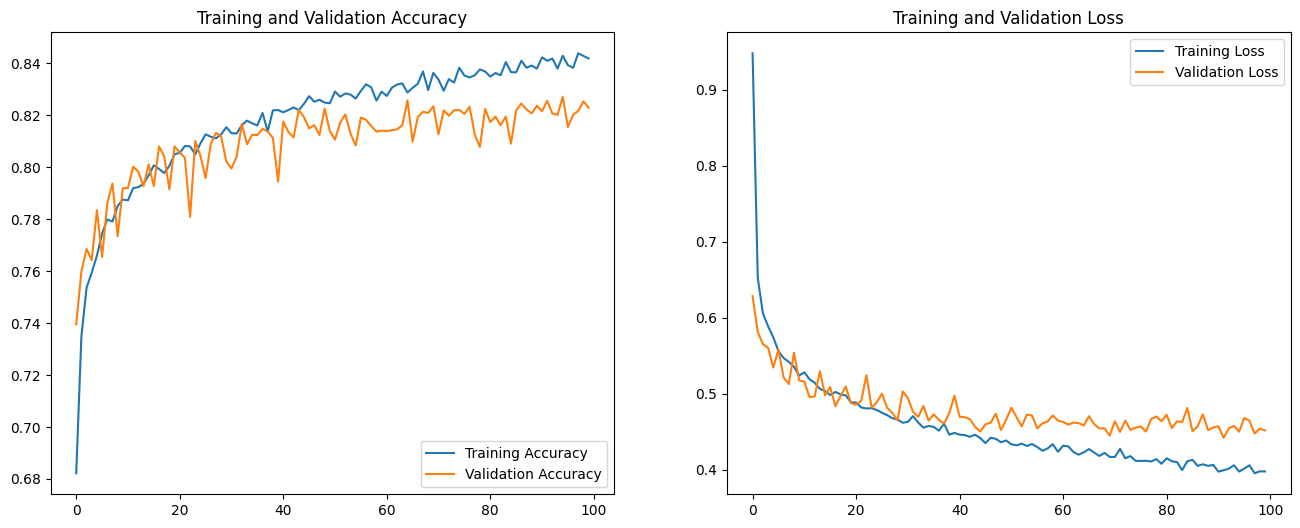

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 27s 57ms/step - loss: 0.6550 - accuracy: 0.7563 - val_loss: 0.4418 - val_accuracy: 0.8242
Epoch 2/100
360/360 [==============================] - 20s 56ms/step - loss: 0.4782 - accuracy: 0.8098 - val_loss: 0.3929 - val_accuracy: 0.8435
Epoch 3/100
360/360 [==============================] - 19s 54ms/step - loss: 0.4453 - accuracy: 0.8224 - val_loss: 0.3997 - val_accuracy: 0.8430
Epoch 4/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4211 - accuracy: 0.8323 - val_loss: 0.3789 - val_accuracy: 0.8505
Epoch 5/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4129 - accuracy: 0.8373 - val_loss: 0.4332 - val_accuracy: 0.8310
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3965 - accuracy: 0.8450 - v

360/360 [==============================] - 19s 53ms/step - loss: 0.2850 - accuracy: 0.8904 - val_loss: 0.3106 - val_accuracy: 0.8845
Epoch 62/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2921 - accuracy: 0.8850 - val_loss: 0.3146 - val_accuracy: 0.8850
Epoch 63/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2919 - accuracy: 0.8880 - val_loss: 0.3049 - val_accuracy: 0.8871
Epoch 64/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2852 - accuracy: 0.8892 - val_loss: 0.3073 - val_accuracy: 0.8828
Epoch 65/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2873 - accuracy: 0.8861 - val_loss: 0.3081 - val_accuracy: 0.8857
Epoch 66/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2901 - accuracy: 0.8878 - val_loss: 0.3061 - val_accuracy: 0.8842
Epoch 67/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2835 - accuracy: 0.8897 - val_loss: 0.3081 - val_accuracy

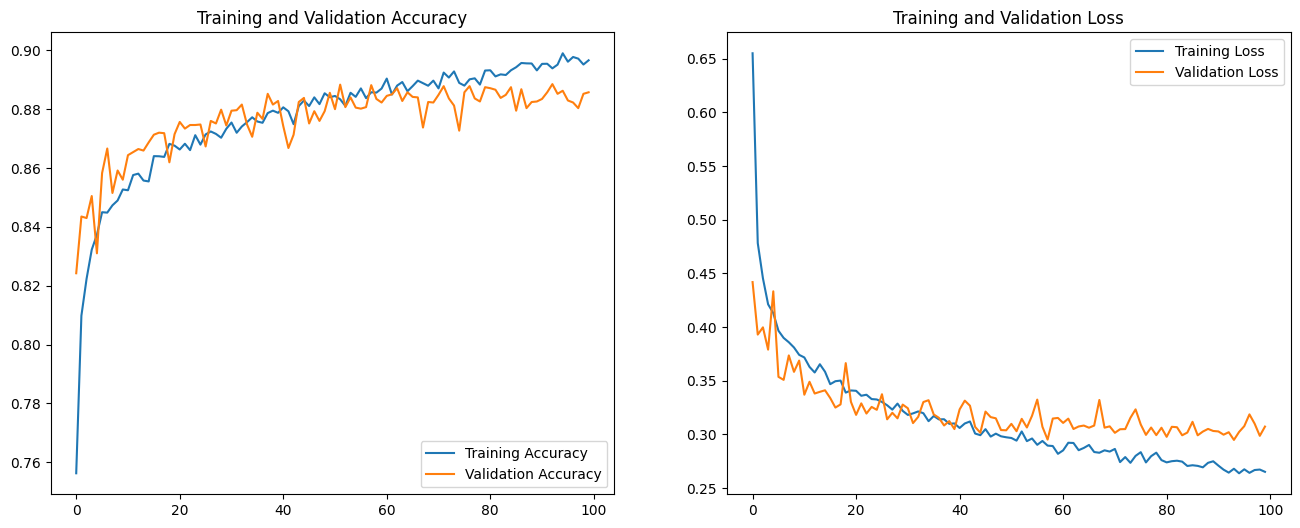

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 27s 56ms/step - loss: 0.6239 - accuracy: 0.7703 - val_loss: 0.4036 - val_accuracy: 0.8460
Epoch 2/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4433 - accuracy: 0.8222 - val_loss: 0.3847 - val_accuracy: 0.8470
Epoch 3/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4171 - accuracy: 0.8342 - val_loss: 0.3837 - val_accuracy: 0.8383
Epoch 4/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3946 - accuracy: 0.8431 - val_loss: 0.3739 - val_accuracy: 0.8513
Epoch 5/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3892 - accuracy: 0.8464 - val_loss: 0.3460 - val_accuracy: 0.8656
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3781 - accuracy: 0.8524 - val_loss: 0.3226 - va

360/360 [==============================] - 19s 53ms/step - loss: 0.2771 - accuracy: 0.8906 - val_loss: 0.2610 - val_accuracy: 0.8996
Epoch 57/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2700 - accuracy: 0.8932 - val_loss: 0.2752 - val_accuracy: 0.8911
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2732 - accuracy: 0.8941 - val_loss: 0.2611 - val_accuracy: 0.9012
Epoch 59/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2691 - accuracy: 0.8960 - val_loss: 0.2746 - val_accuracy: 0.8939
Epoch 60/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2678 - accuracy: 0.8959 - val_loss: 0.2712 - val_accuracy: 0.8934
Epoch 61/100
360/360 [==============================] - 19s 52ms/step - loss: 0.2709 - accuracy: 0.8930 - val_loss: 0.2635 - val_accuracy: 0.8981
Epoch 62/100
360/360 [==============================] - 19s 53ms/step - loss: 0.2695 - accuracy: 0.8929 - val_loss: 0.2691 - val_accuracy

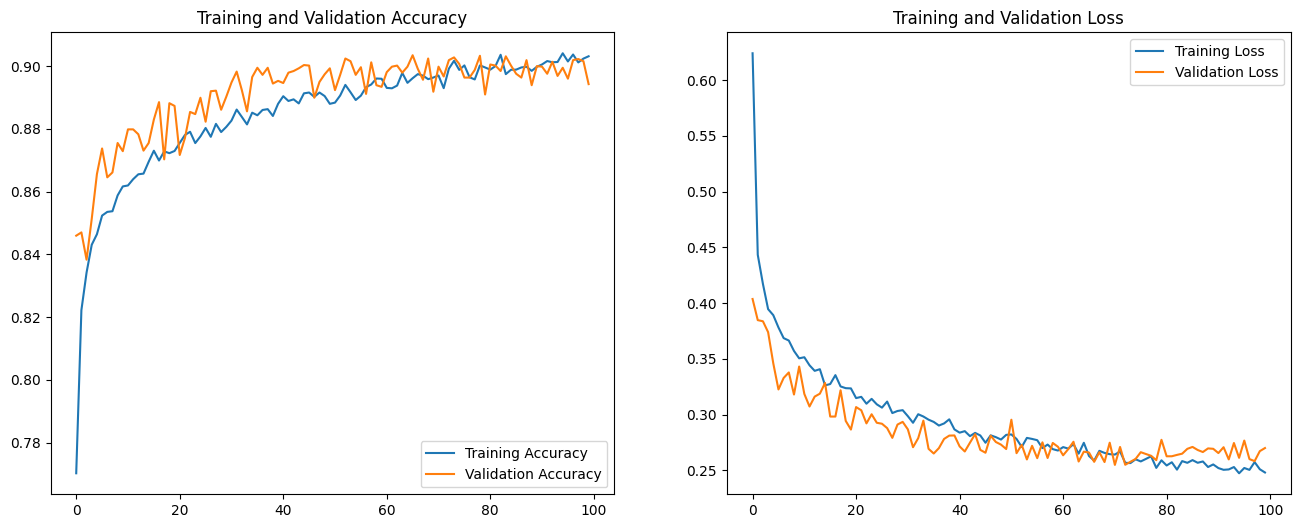

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 27s 57ms/step - loss: 0.6957 - accuracy: 0.7260 - val_loss: 0.5176 - val_accuracy: 0.7787
Epoch 2/100
360/360 [==============================] - 19s 53ms/step - loss: 0.5506 - accuracy: 0.7733 - val_loss: 0.5342 - val_accuracy: 0.7723
Epoch 3/100
360/360 [==============================] - 19s 52ms/step - loss: 0.5162 - accuracy: 0.7854 - val_loss: 0.4642 - val_accuracy: 0.8041
Epoch 4/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4981 - accuracy: 0.7962 - val_loss: 0.4774 - val_accuracy: 0.8071
Epoch 5/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4748 - accuracy: 0.8072 - val_loss: 0.4561 - val_accuracy: 0.8222
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4675 - accuracy: 0.8087 - v

360/360 [==============================] - 19s 52ms/step - loss: 0.3522 - accuracy: 0.8588 - val_loss: 0.3692 - val_accuracy: 0.8536
Epoch 57/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3486 - accuracy: 0.8579 - val_loss: 0.3851 - val_accuracy: 0.8470
Epoch 58/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3504 - accuracy: 0.8580 - val_loss: 0.3860 - val_accuracy: 0.8541
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3476 - accuracy: 0.8604 - val_loss: 0.3871 - val_accuracy: 0.8498
Epoch 60/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3483 - accuracy: 0.8586 - val_loss: 0.3706 - val_accuracy: 0.8548
Epoch 61/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3435 - accuracy: 0.8636 - val_loss: 0.3986 - val_accuracy: 0.8451
Epoch 62/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3380 - accuracy: 0.8666 - val_loss: 0.3962 - val_accuracy

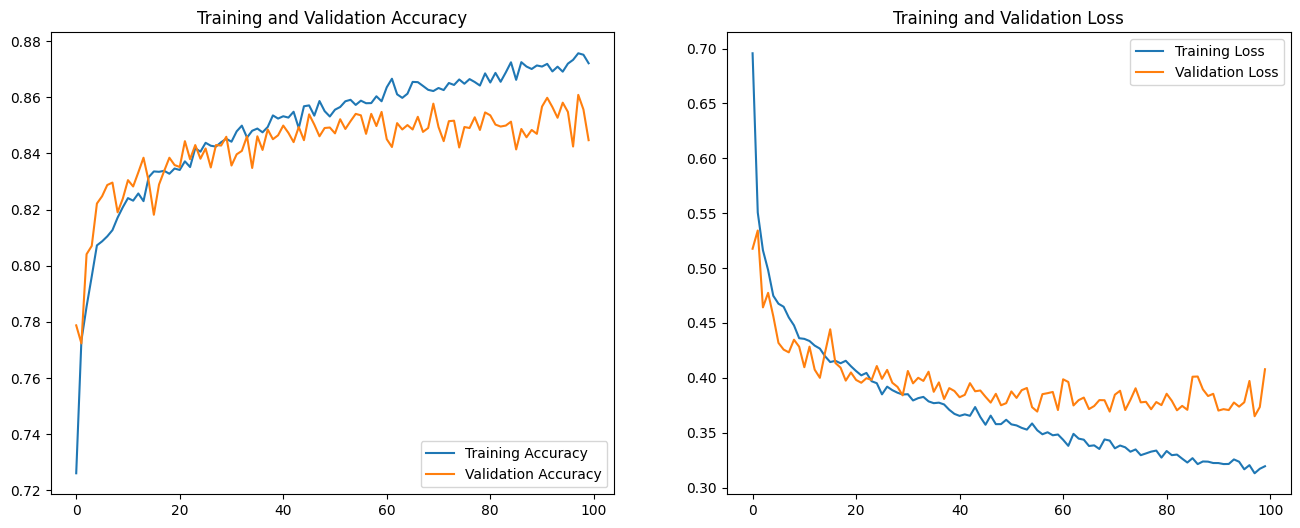

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 27s 56ms/step - loss: 0.6586 - accuracy: 0.7397 - val_loss: 0.4746 - val_accuracy: 0.8022
Epoch 2/100
360/360 [==============================] - 19s 53ms/step - loss: 0.5132 - accuracy: 0.7895 - val_loss: 0.4741 - val_accuracy: 0.8182
Epoch 3/100
360/360 [==============================] - 19s 52ms/step - loss: 0.4779 - accuracy: 0.8040 - val_loss: 0.4255 - val_accuracy: 0.8331
Epoch 4/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4611 - accuracy: 0.8119 - val_loss: 0.4262 - val_accuracy: 0.8366
Epoch 5/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4447 - accuracy: 0.8198 - val_loss: 0.3983 - val_accuracy: 0.8442
Epoch 6/100
360/360 [==============================] - 19s 53ms/step - loss: 0.4343 - accuracy: 0.8241 - val_loss: 0.4099 - va

360/360 [==============================] - 19s 53ms/step - loss: 0.3153 - accuracy: 0.8741 - val_loss: 0.3201 - val_accuracy: 0.8835
Epoch 57/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3187 - accuracy: 0.8742 - val_loss: 0.3410 - val_accuracy: 0.8790
Epoch 58/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3111 - accuracy: 0.8756 - val_loss: 0.3308 - val_accuracy: 0.8802
Epoch 59/100
360/360 [==============================] - 19s 53ms/step - loss: 0.3208 - accuracy: 0.8724 - val_loss: 0.3245 - val_accuracy: 0.8784
Epoch 60/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3181 - accuracy: 0.8749 - val_loss: 0.3140 - val_accuracy: 0.8809
Epoch 61/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3191 - accuracy: 0.8722 - val_loss: 0.3210 - val_accuracy: 0.8798
Epoch 62/100
360/360 [==============================] - 19s 52ms/step - loss: 0.3097 - accuracy: 0.8768 - val_loss: 0.3205 - val_accuracy

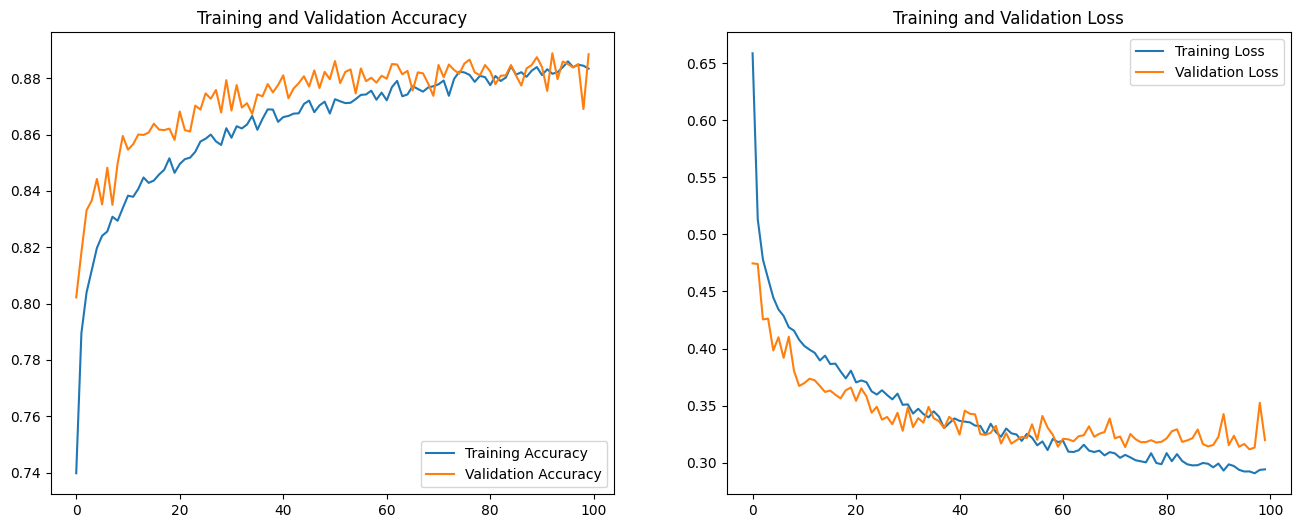

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("resnet101_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("resnet101_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("resnet101_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("resnet101_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("resnet101_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("resnet101_nontrainable/res_ycrcb_nonpre.csv", index=False)